<a href="https://colab.research.google.com/github/Womics/lab_rotation/blob/main/first_workat_labroat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIFでニューロンのモデルを作成**

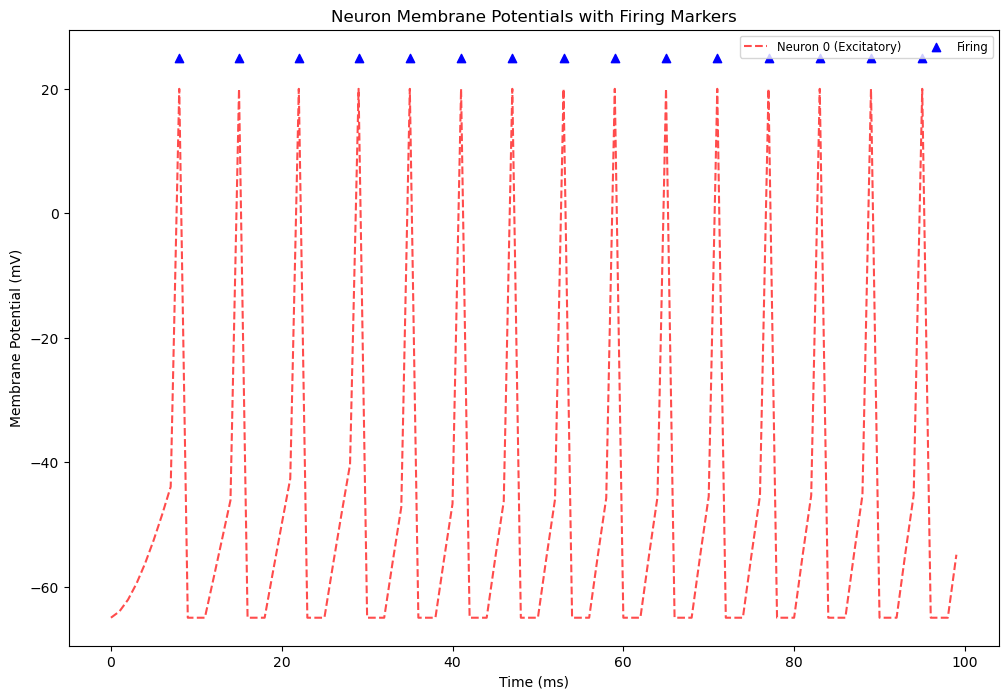

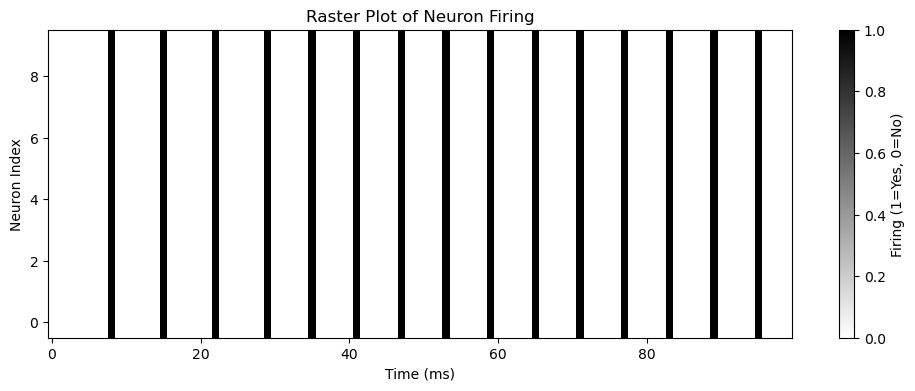

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
aaa

class LIFNeuron:
    def __init__(self, rest: float = -65, ref: float = 3, th: float = -40, tc: float = 20, peak: float = 20, dt: float = 1):
        self.rest = rest
        self.ref = ref
        self.th = th
        self.tc = tc
        self.peak = peak
        self.dt = dt
        self.v = rest
        self.tlast = -ref

    def calc(self, inputs, weights, time=100, tci=10):
        i = 0
        monitor = []
        firing_times = []

        for t in range(int(time / self.dt)):
            current_time = t * self.dt
            di = (current_time > self.tlast + self.ref) * (-i + np.sum(inputs[:, t] * weights))
            i += di * self.dt / tci

            dv = (current_time > self.tlast + self.ref) * ((-self.v + self.rest) + i)
            self.v += dv * self.dt / self.tc

            if self.v >= self.th:
                self.tlast = current_time
                self.v = self.peak
                monitor.append(self.v)
                firing_times.append(current_time)  # 発火タイミングを記録
                self.v = self.rest
            else:
                monitor.append(self.v)

        return monitor, firing_times

if __name__ == '__main__':
    num_neurons = 10
    time = 100
    dt = 1
    nt = int(time / dt)
    ratio_excitatory = 4
    ratio_inhibitory = 1
    num_excitatory = int(num_neurons * ratio_excitatory / (ratio_excitatory + ratio_inhibitory))
    num_inhibitory = num_neurons - num_excitatory

    neurons = [LIFNeuron() for _ in range(num_neurons)]
    
    inputs = np.ones((num_neurons, nt))
    inputs[:, 0] = 0

    weights = np.random.uniform(20, 50, num_neurons)
    weights[num_excitatory:] *= -1

    # 興奮性および抑制性ニューロンのIDを保存
    excitatory_ids = list(range(num_excitatory))
    inhibitory_ids = list(range(num_excitatory, num_neurons))

    # シナプス行列 S を作成し、自己結合がないように設定
    S = np.random.uniform(-1, 1, (num_neurons, num_neurons))
    S[:num_excitatory, :] = np.abs(S[:num_excitatory, :])  # 興奮性ニューロンは正の結合強度
    S[num_excitatory:, :] = -np.abs(S[num_excitatory:, :])  # 抑制性ニューロンは負の結合強度
    np.fill_diagonal(S, 0)  # 自己結合を防ぐため対角要素を0に設定

    membrane_potentials = []
    firing_array = np.zeros((num_neurons, nt), dtype=int)
    firing_times_all = []

    for idx, neuron in enumerate(neurons):
        v, firing_times = neuron.calc(inputs, weights, time)
        membrane_potentials.append(v)
        firing_times_all.append(firing_times)
        for t in firing_times:
            firing_array[idx, int(t / dt)] = 1

    membrane_potentials = np.array(membrane_potentials)

    # Plotting the membrane potentials with firing markers for Neuron 0
    plot_nt = nt
    plot_time = np.arange(plot_nt) * dt

    plt.figure(figsize=(12, 8))
    plt.plot(plot_time, membrane_potentials[0, :plot_nt], 'r--', label='Neuron 0 (Excitatory)', alpha=0.7)
    plt.scatter(firing_times_all[0], np.array(firing_times_all[0]) * 0 + 25, color='blue', marker='^', label='Firing', zorder=3)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title('Neuron Membrane Potentials with Firing Markers')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.show()

    # Plotting the raster plot
    plt.figure(figsize=(12, 4))
    plt.imshow(firing_array, aspect='auto', cmap='binary', origin='lower')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron Index')
    plt.title('Raster Plot of Neuron Firing')
    plt.colorbar(label='Firing (1=Yes, 0=No)')
    plt.show()


In [18]:
import pandas as pd
# firing_arrayをDataFrameに変換
firing_array = np.array(membrane_potentials)
firing_df = pd.DataFrame(firing_array, columns=[f'Time_{i*dt:.1f}ms' for i in range(nt)])

# pickleで保存
firing_df.to_pickle('neuron_firing_data.pkl')

print("Data saved as pickle file.")
firing_df.head(10)

Data saved as pickle file.


,Time_0.0ms,Time_1.0ms,Time_2.0ms,Time_3.0ms,Time_4.0ms,Time_5.0ms,Time_6.0ms,Time_7.0ms,Time_8.0ms,Time_9.0ms,...,Time_990.0ms,Time_991.0ms,Time_992.0ms,Time_993.0ms,Time_994.0ms,Time_995.0ms,Time_996.0ms,Time_997.0ms,Time_998.0ms,Time_999.0ms
0,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
1,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
2,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
3,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
4,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
5,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
6,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
7,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
8,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0
9,-65.0,-63.733546,-61.390606,-58.138985,-54.1267,-49.484108,-44.325818,20.0,-65.0,-65.0,...,-52.335459,-40.304144,20.0,-65.0,-65.0,-65.0,-52.335459,-40.304144,20.0,-65.0


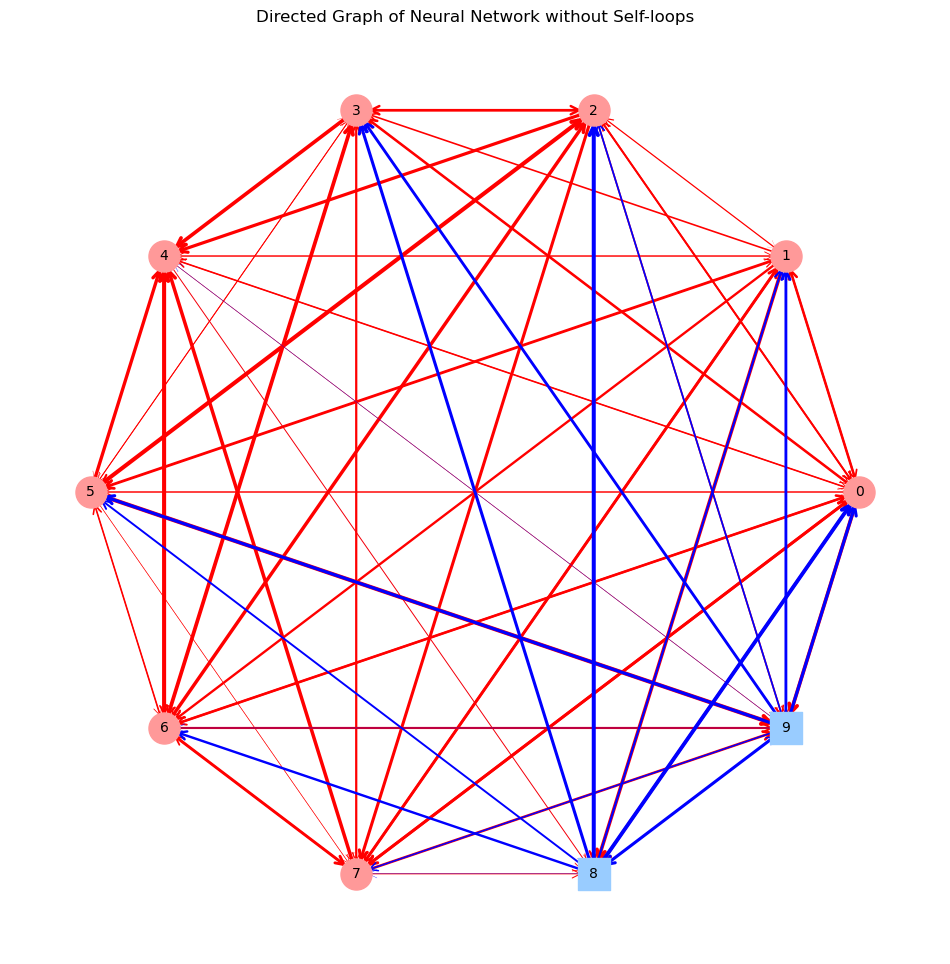

In [20]:
# グラフの作成とプロット
G = nx.DiGraph()

for neuron_id in range(num_neurons):
    G.add_node(neuron_id, label=f"Neuron {neuron_id}")

for i in range(num_neurons):
    for j in range(num_neurons):
        if S[i, j] != 0:
            G.add_edge(i, j, weight=S[i, j])

pos = nx.circular_layout(G)

# Excitatoryニューロンを赤い円で、Inhibitoryニューロンを青い四角で描画
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, nodelist=excitatory_ids, node_color='#ff9999', node_shape='o', node_size=500, label='Excitatory')
nx.draw_networkx_nodes(G, pos, nodelist=inhibitory_ids, node_color='#99ccff', node_shape='s', node_size=500, label='Inhibitory')

# ラベルを描画
nx.draw_networkx_labels(G, pos, labels={i: f"{i}" for i in range(num_neurons)}, font_size=10)

# エッジの描画（厚みと色に変化をつける）
for src, dst, data in G.edges(data=True):
    weight = abs(data['weight'])  # 接続強度の絶対値
    width = weight * 3  # エッジの幅をスケール
    color = 'red' if src in excitatory_ids else 'blue'
    nx.draw_networkx_edges(G, pos, edgelist=[(src, dst)], edge_color=color, width=width, arrows=True, arrowstyle='->', arrowsize=15)

plt.title("Directed Graph of Neural Network without Self-loops")
plt.axis('off')
plt.show()

# 発火データの取得
membrane_potentials = []
firing_array = np.zeros((num_neurons, nt), dtype=int)
firing_times_all = []

for idx, neuron in enumerate(neurons):
    v, firing_times = neuron.calc(inputs, weights, time)
    membrane_potentials.append(v)
    firing_times_all.append(firing_times)
    for t in firing_times:
        firing_array[idx, int(t / dt)] = 1



# **estimation function.c++をpythonで書き直した。**

In [23]:
import numpy as np
from scipy.stats import norm
from multiprocessing import Pool
from tqdm import tqdm



# `vPow`関数 - ベクトルごとのべき乗計算
def v_pow(base, exp):
    return np.power(base, exp)

# `ZeroOne`関数 - 各要素の値を 1 から減算
def zero_one(x):
    return 1 - x

# `ColSums_cpp`関数 - 各列の合計
def col_sums_cpp(X):
    return np.sum(X, axis=0)

# `Pruning_cpp`関数 - 指定された条件に基づいてマトリクスの要素を0に設定
def pruning_cpp(West, z):
    n = West.shape[1]
    for j in range(n):
        if z[j] == 1:
            West[:, j][West[:, j] < 0] = 0
        elif z[j] == 0:
            West[:, j][West[:, j] > 0] = 0
    return West

# `EstimateConnections_cpp`関数 - 神経接続の推定
def EstimateConnections_cpp(Lambda, Eta, nitr):
    n = Lambda.shape[1]
    I = np.eye(n)
    Theta = np.random.rand(n, n)
    np.fill_diagonal(Theta, 0)

    
    for _ in range(nitr):
        # step1
        West = Lambda @ (I - Theta)

        # step2
        for i in range(n):
            for j in range(n):
                Theta[i, j] = norm.cdf(West[i, j] + Eta[i, j])
        np.fill_diagonal(Theta, 0)

        # step3
        LT = Lambda @ Theta
        Lambda = Lambda - np.diag(np.diag(Lambda)) + np.diag(np.diag(LT))
    return West

# `EstimateConnectionsWithLabel_cpp`関数 - ラベル付きの神経接続推定
def EstimateConnectionsWithLabel_cpp(Lambda, Eta, z, nitr):
    n = Lambda.shape[1]
    I = np.eye(n)
    Theta = np.random.rand(n, n)
    np.fill_diagonal(Theta, 0)

    for _ in range(nitr):
        # step1
        West = Lambda @ (I - Theta)

        # step2
        West = pruning_cpp(West, z)

        # step3
        for i in range(n):
            for j in range(n):
                Theta[i, j] = norm.cdf(West[i, j] + Eta[i, j])
        np.fill_diagonal(Theta, 0)

        # step4
        LT = Lambda @ Theta
        Lambda = Lambda - np.diag(np.diag(Lambda)) + np.diag(np.diag(LT))
    return West

# `Liklihood_cpp`関数 - 尤度の計算
def likelihood_cpp(Lambda, Eta, z, nitr):
    n = Lambda.shape[1]
    I = np.eye(n)
    
    # Westの計算
    West = EstimateConnectionsWithLabel_cpp(Lambda, Eta, z, nitr)

    # ベクトル化でThetaを計算
    Theta = norm.cdf(West + Eta)

    # Lambdaの対角成分を保ったまま更新
    LT = Lambda @ Theta
    Lambda[np.diag_indices(n)] = LT.diagonal()

    # Errorの計算をベクトル化
    Error = Lambda - West @ np.linalg.inv(I - Theta)

    # Lambdaの条件に基づき、Errorでの条件を適用して`norm.pdf`計算
    mask = Lambda >= 0
    like = np.prod(norm.pdf(Error[mask], 0, np.sqrt(0.15)))
    return like


def gibbs_cpp(Lambda, Eta, alpha, z, ind, likelihood_cache):
    # メモリ不足を防ぐため、キャッシュサイズ制御を追加
    max_cache_size = 100
    if len(likelihood_cache) > max_cache_size:
        likelihood_cache.clear()  # キャッシュのクリア
    # 状態変更による z1 と z0 の生成
    z1, z0 = z.copy(), z.copy()
    z1[ind], z0[ind] = 1, 0

    epsilon = 1e-10  # 小さな値を追加してゼロ除算を回避

    # キャッシュの利用による計算の高速化
    if tuple(z1) not in likelihood_cache:
        likelihood_cache[tuple(z1)] = likelihood_cpp(Lambda, Eta, z1, 10)
    if tuple(z0) not in likelihood_cache:
        likelihood_cache[tuple(z0)] = likelihood_cpp(Lambda, Eta, z0, 10)
    like1 = likelihood_cache[tuple(z1)]
    like0 = likelihood_cache[tuple(z0)]

    # fact の計算を高速化するために log-sum-exp トリックを使用
    log_fact1 = np.sum(np.log(alpha + epsilon) * z1 + np.log(1 - alpha + epsilon) * (1 - z1))
    log_fact0 = np.sum(np.log(alpha + epsilon) * z0 + np.log(1 - alpha + epsilon) * (1 - z0))

    # np.log1p を用いて数値の安定性を強化
    prob = np.exp(np.log1p(like1) + log_fact1 - np.log1p(np.exp(np.log1p(like1) + log_fact1) + np.exp(np.log1p(like0) + log_fact0) + epsilon))
    return 1 if np.random.uniform(0, 1) < prob else 0
# `RemoveElem`関数 - 指定されたインデックスの要素を削除
def remove_elem(x, idx):
    return np.delete(x, idx)

# `Sigmoid_cpp`関数 - シグモイド関数の計算
def sigmoid_cpp(x):
    return 1 / (1 + np.exp(-x))

# `SampleZ_cpp`関数 - 0か1をランダムにサンプリング
def sample_z_cpp(n):
    return np.random.choice([0, 1], size=n, p=[0.5, 0.5])

# `rBinom_cpp`関数 - ベルヌーイ分布のサンプリング
def rbinom_cpp(n, beta):
    return np.random.binomial(1, beta, n)


# `estimate_excitatory_probabilities_eproj_gibbs_cpp` の並列化
def estimate_excitatory_probabilities_eproj_gibbs_cpp(Lambda, Eta, nitr_em, nsamp, excl_ratio, likelihood_cache, nclust):
    n = Lambda.shape[1]
    nexcl = round(nsamp * excl_ratio)
    ngibbs = nsamp - nexcl
    eps = 1e-16

    Z1 = np.zeros((nsamp, n))
    Z2 = np.zeros((nsamp, n))
    alpha = np.full(n, 0.5)
    beta = np.full(n, 0.5)
    pre_alpha = alpha.copy()

    for itr in range(nitr_em):
        #print(f"Iteration {itr+1}")
        
        samp_z = sample_z_cpp(n) if itr == 0 else samp_z
        for i in range(nsamp):
            for j in range(n):
                samp_z[j] = gibbs_cpp(Lambda, Eta, alpha, samp_z, j, likelihood_cache)
            Z1[i, :] = samp_z.copy()

        subZ1 = Z1[nexcl:, :]
        C = np.zeros((ngibbs, n))
        for i in range(ngibbs):
            print("for i in range(ngibbs):")
            state = subZ1[i, :]
            for j in range(n):
                estate = np.delete(state, j)
                ebeta = np.delete(beta, j)
                
                z1 = state.copy()
                z0 = state.copy()
                z1[j] = 1
                z0[j] = 0

                like1 = likelihood_cpp(Lambda, Eta, z1, 5)
                like0 = likelihood_cpp(Lambda, Eta, z0, 5)
                fact1 = np.prod(v_pow(alpha, z1) * v_pow(zero_one(alpha), zero_one(z1)))
                fact0 = np.prod(v_pow(alpha, z0) * v_pow(zero_one(alpha), zero_one(z0)))

                p1 = max(like1 * fact1, eps)
                p0 = max(like0 * fact0, eps)
                
                C[i, j] = np.log(p1) - np.log(p0)

        a = np.mean(C, axis=0)
        beta = sigmoid_cpp(a)

        for i in range(nsamp):
            samp_z = rbinom_cpp(n, beta)
            Z2[i, :] = samp_z

        alpha = np.mean(Z2, axis=0)
        breakornot=np.linalg.norm(alpha - pre_alpha)
        print(breakornot)
        if breakornot < 1e-3:
            print("break")
            break
        pre_alpha = alpha.copy()
    return alpha


# **estimating function.Rの内容をpythonに変換**


In [24]:
import numpy as np
import pandas as pd
from scipy.special import erfinv
from multiprocessing import Pool, cpu_count

def calculate_pre_spike(data, pre_period, post_period):
    L = data.shape[1]
    if pre_period == 1:
        pre_spike = data.iloc[:, :L - post_period]
    else:
        pre_tmp = data.iloc[:, :L - post_period].T
        pre_spike = np.convolve(pre_tmp.values.flatten(), np.ones(pre_period), mode='valid')
        discard_elements = pre_spike.shape[0] - ((L - post_period - pre_period + 1) * data.shape[0])
        pre_spike = pre_spike[:-discard_elements].reshape(L - post_period - pre_period + 1, data.shape[0]).T
        pre_spike[pre_spike > 0] = 1
        pre_spike = pd.DataFrame(pre_spike)
    return pre_spike

def calculate_post_spike(data, pre_period, post_period):
    L = data.shape[1]
    if post_period == 1:
        post_spike = data.iloc[:, pre_period:L]
    else:
        post_tmp = data.iloc[:, pre_period:L].T
        post_spike = np.convolve(post_tmp.values.flatten(), np.ones(post_period), mode='valid')
        discard_elements = post_spike.shape[0] - ((L - pre_period - post_period + 1) * data.shape[0])
        post_spike = post_spike[:-discard_elements].reshape(L - pre_period - post_period + 1, data.shape[0]).T
        post_spike[post_spike > 0] = 1
        post_spike = pd.DataFrame(post_spike)
    return post_spike

def probit(p):
    return np.sqrt(2) * erfinv(2 * p - 1)

def calc_probs(idx, pre_spike, post_spike, firing_sum):
    i, j = idx
    Sj = pre_spike.iloc[i, :].values
    Si = post_spike.iloc[j, :].values
    S_sum = Si + Sj
    S_dif = Si - Sj
    prob_fire = np.sum(S_sum == 2) / firing_sum[i] if firing_sum[i] > 0 else 0
    prob_rest = np.sum(S_dif == 1) / (post_spike.shape[1] - firing_sum[i]) if post_spike.shape[1] - firing_sum[i] > 0 else 0
    return prob_fire, prob_rest

def calculate_spike_prob_matrix(pre_spike, post_spike, nclust):
    N = post_spike.shape[0]
    firing_sum = np.sum(pre_spike, axis=1)
    
    # 並列処理のために必要な引数を`calc_probs`関数に渡す
    with Pool(nclust) as pool:
        results = pool.starmap(calc_probs, [(idx, pre_spike, post_spike, firing_sum) for idx in [(i, j) for i in range(N) for j in range(N)]])
    
    prob_fire = np.array([res[0] for res in results]).reshape(N, N)
    prob_rest = np.array([res[1] for res in results]).reshape(N, N)
    prob_fire[prob_fire == 0] = np.finfo(float).eps
    prob_rest[prob_rest == 0] = np.finfo(float).eps
    
    array_prob = np.zeros((N, N, 2))
    array_prob[:, :, 0] = prob_fire
    array_prob[:, :, 1] = prob_rest
    return array_prob
def estimate_pseudo_connections(prob_fire, prob_rest):
    return probit(prob_fire) - probit(prob_rest)

def estimate_connections(Lambda, Eta, z, param):
    num_itr = param['number_of_iteration']
    if z is None:
        West = EstimateConnections_cpp(Lambda, Eta, num_itr)
    else:
        West = EstimateConnectionsWithLabel_cpp(Lambda, Eta, z, num_itr)
    return West



# グローバル関数として定義
def gibbs_sample(i, Lambda, Eta, proj_type, nitr_em, nsamp, excl_ratio, nclust):
    likelihood_cache = {}
    if proj_type == 'e':
        return estimate_excitatory_probabilities_eproj_gibbs_cpp(Lambda, Eta, nitr_em, nsamp, excl_ratio, likelihood_cache, nclust)
    elif proj_type == 'm':
        return estimate_excitatory_probabilities_mproj_gibbs_cpp(Lambda, Eta, nitr_em, nsamp, excl_ratio, likelihood_cache, nclust)

def estimate_excitatory_label_gibbs(Lambda, Eta, proj_type, param):
    nitr_em = param['number_of_EM_iteration']
    nalpha = param['number_of_alpha']
    nsamp = param['number_of_Gibbs_sampler']
    excl_ratio = param['gibbs_exclude_ratio']
    nclust = min(param['number_of_cluster'], Pool()._processes)  # nclustを最大プロセス数に制限

    with Pool(nclust) as pool:
        alpha_samples = pool.starmap(
            gibbs_sample, 
            [(i, Lambda, Eta, proj_type, nitr_em, nsamp, excl_ratio, nclust) for i in range(nalpha)]
        )

    Alpha = np.vstack(alpha_samples)
    z = (np.mean(Alpha, axis=0) != 1).astype(int)
    return z

# **main.Rをpythonで書き直す**

In [ ]:
import pandas as pd

filepath = "neuron_firing_data.pkl"
selected_neurons_file = "selected_neurons.txt"

print("Reading data...")

# selected_neurons.txtファイルを読み込み、リストとして取得
with open(selected_neurons_file, "r") as file:
    selected_neurons = [int(line.strip()) for line in file]
# pickleファイルを読み込む
data = pd.read_pickle(filepath)
selected_data = data.iloc[selected_neurons]
print("Data loaded successfully.")
selected_data.head()



Reading data...


In [ ]:
import numpy as np
import pandas as pd
import gc
import pickle  # readRDSの代替としてpickleを使用
from scipy.special import erfinv



# パラメータの設定
pre_period =10

post_period = 1

param = {
    "excitatory_threshold": 0.5,
    "number_of_iteration": 10,
    "number_of_EM_iteration": 50,
    "number_of_cluster": 10,
    "number_of_alpha": 1,
    "number_of_Gibbs_sampler": 1,
    "gibbs_exclude_ratio": 0.02
}

# データの読み込み
print("Reading data ..")
filepath = "neuron_firing_data.pkl"
data = pd.read_pickle(filepath)
selected_data = data.iloc[selected_neurons]
print("Data loaded successfully.")


# スパイクの前処理
print("Preprocessing spikes..")
pre_spike = calculate_pre_spike(selected_data, pre_period, post_period)
post_spike = calculate_post_spike(selected_data, pre_period, post_period)







In [ ]:
# スパイク確率行列の計算
array_prob = calculate_spike_prob_matrix(pre_spike, post_spike, param["number_of_cluster"])
print(array_prob)



In [ ]:
prob_fire = array_prob[:, :, 0]
prob_rest = array_prob[:, :, 1]
del pre_spike, post_spike

In [ ]:
# 疑似接続の推定
Lambda = estimate_pseudo_connections(prob_fire, prob_rest)
Eta = np.vectorize(probit)(prob_rest)
del prob_fire, prob_rest

# -infを-10に置き換え
Lambda = np.where(np.isinf(Lambda) & (Lambda < 0), -10, Lambda)
print(Lambda)


In [ ]:
# 興奮ラベルの推定
print("Estimating excitatory label...")
z = estimate_excitatory_label_gibbs(Lambda, Eta, proj_type="e", param=param)

In [ ]:
# selected_data に 'ID' 列を追加
selected_data = selected_data.copy()  # 明示的にコピーを作成して編集
selected_data['ID'] = selected_data.index  # 'ID' 列を追加して、インデックスを設定
print(z)
# 神経接続の推定
print("Estimating neural connections...")


In [ ]:
West = estimate_connections(Lambda, Eta, np.ravel(
    [1, 1, 1, 1, 1, 1, 1, 1,0,0]
), param)
gc.collect()
print("-> done.")

In [ ]:
# WestをDataFrameに変換し、selected_data['ID']を使って行列のインデックスとカラムに設定
West_df = pd.DataFrame(West, index=selected_data['ID'], columns=selected_data['ID'])

print("West matrix with IDs:")
West_df.head()


# 対角成分を0に設定
np.fill_diagonal(West_df.values, 0)

# 少数第4位で切り捨て
West_df = West_df.applymap(lambda x: np.floor(x * 10**4) / 10**4)

# 各行で絶対値が最も大きい値が正なら他の負の値を0にし、負なら他の正の値を0にする
for i in range(West_df.shape[0]):
    row = West_df.iloc[i, :].copy()
    max_index = row.abs().idxmax()
    if row[max_index] > 0:
        row[row < 0] = 0
    else:
        row[row > 0] = 0
    West_df.iloc[i, :] = row
 # 各列で絶対値が最も大きい値が正なら他の負の値を0にし、負なら他の正の値を0にする
for j in range(West_df.shape[1]):
    col = West_df.iloc[:, j].copy()
    max_index = col.abs().idxmax()
    if col[max_index] > 0:
        col[col < 0] = 0
    else:
        col[col > 0] = 0
    West_df.iloc[:, j] = col



# 各行で絶対値が大きいものから10データだけ残し、残りを0にする
for i in range(West_df.shape[0]):
    row = West_df.iloc[i, :].copy()  # 元の行データのコピーを取得
    largest_indices = row.abs().nlargest(8).index
    # 残すべきインデックス以外の要素を0に設定
    row[~row.index.isin(largest_indices)] = 0
    West_df.iloc[i, :] = row  # 行全体を上書き

# 各列で絶対値が大きいものから10データだけ残し、残りを0にする
for j in range(West_df.shape[1]):
    col = West_df.iloc[:, j].copy()  # 元の列データのコピーを取得
    largest_indices = col.abs().nlargest(8).index
    # 残すべきインデックス以外の要素を0に設定
    col[~col.index.isin(largest_indices)] = 0
    West_df.iloc[:, j] = col  # 列全体を上書き
    
for i in range(West_df.shape[0]):
    col = West_df.iloc[i, :].copy()  # 元の列データのコピーを取得
    largest_indices = col.abs().nlargest(8).index
    # 残すべきインデックス以外の要素を0に設定
    col[~col.index.isin(largest_indices)] = 0
    West_df.iloc[i, :] = col  # 列全体を上書き

In [ ]:

West_df.head(33)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 正規化のためにWest_dfのエッジ重みの絶対値最大値を取得
max_weight = West_df.abs().values.max()
scaling_factor = 10 / abs(max_weight)  # 正規化のスケーリング係数

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph based on West_df
for i in West_df.index:
    G.add_node(i, label=f"Neuron {i}")
    for j in West_df.columns:
        weight = West_df.at[i, j] * scaling_factor  # 正規化した重みを使用
        if weight != 0:
            G.add_edge(i, j, weight=weight)

# Define excitatory and inhibitory neurons based on the weights in West_df
exc_nodes = set()  # Excitatory neurons
inh_nodes = set()  # Inhibitory neurons

# Determine neuron type based on edge weights
for i, j in G.edges():
    if G[i][j]['weight'] > 0:
        exc_nodes.add(i)
    elif G[i][j]['weight'] < 0:
        inh_nodes.add(i)

# Make sure that all nodes are categorized as either excitatory or inhibitory
exc_nodes = list(exc_nodes)
inh_nodes = list(inh_nodes)

# Define positions for circular layout in ID order (clockwise)
num_neurons = len(West_df.index)
angles = np.linspace(0, 2 * np.pi, num_neurons, endpoint=False)
pos = {neuron_id: (np.cos(angle), np.sin(angle)) for neuron_id, angle in zip(sorted(West_df.index), angles)}

# Plotting the graph
plt.figure(figsize=(12, 12))

# Draw excitatory neurons as red circles
nx.draw_networkx_nodes(G, pos, nodelist=exc_nodes, node_color='#ff9999', node_shape='o', node_size=500, label='Excitatory')

# Draw inhibitory neurons as blue squares
nx.draw_networkx_nodes(G, pos, nodelist=inh_nodes, node_color='#99ccff', node_shape='s', node_size=500, label='Inhibitory')

# Draw labels
nx.draw_networkx_labels(G, pos, labels={i: f"{i}" for i in West_df.index}, font_size=10)

# Draw edges with varying thickness and color
for src, dst, data in G.edges(data=True):
    weight = data['weight']
    width = abs(weight) / 3  # Scale edge width for better visibility
    if weight > 0:  # Excitatory connection
        nx.draw_networkx_edges(G, pos, edgelist=[(src, dst)], edge_color='red', width=width, arrows=True, arrowstyle='->', arrowsize=15)
    else:  # Inhibitory connection
        nx.draw_networkx_edges(G, pos, edgelist=[(src, dst)], edge_color='blue', width=width, arrows=True, arrowstyle='->', arrowsize=15)

# Add a legend
plt.title("Directed Graph of Neurons in Clockwise ID Order with Normalized Weights")
plt.axis('off')
plt.legend(["Excitatory", "Inhibitory"])
plt.show()
